In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-15 13:45:08 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-15 13:45:09 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=7, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-15 13:45:09 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
# model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-15 13:45:40 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks/checking_predicate_generalization, stdin=None, shell=False, universal_newlines=False)
2025-09-15 13:45:40 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks/checking_predicate_generalization, stdin=None, shell=False, universal_newlines=False)
2025-09-15 13:45:40 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-15 13:45:40 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-15 13:45:42 src.models WARNING  Qwen/Qwen2.5-14B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-15 13:45:42 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-09-15 13:45:42 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B-Instruct/resolve/main/config.json HTTP/1.1" 307 0
2025-09-15 13:45:42 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2.5-14B-Instruct/cf98f3b3bbb457ad9e2bb7baf9a0125b6b88caa8/config.json HTTP/1.1" 200 0
2025-09-15 13:45:42 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 307 0
2025-09-15 13:45:42 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2.5-14B-Instruct/cf98f3b3bbb457ad9e2bb7baf9a0125b6b88caa8/tokenizer_config.json HTTP/1.1" 200 0
2025-09-15 13:45:42 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/Qwen/Qwen2.5-14B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

2025-09-15 13:46:03 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B-Instruct/resolve/main/generation_config.json HTTP/1.1" 307 0
2025-09-15 13:46:03 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2.5-14B-Instruct/cf98f3b3bbb457ad9e2bb7baf9a0125b6b88caa8/generation_config.json HTTP/1.1" 200 0
2025-09-15 13:46:03 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-15 13:46:03 src.models INFO     loaded model <Qwen/Qwen2.5-14B-Instruct> | size: 28171.604 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.selection.data import SelectOneTask, CountingTask

#################################################################################
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [6]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

# Options: Surfboard, Temple, Toothbrush, Notebook, Guitar, Apple.
Which among these objects mentioned above is a fruit?
Answer: >> " Apple"


In [7]:
sample.default_option_style = "bulleted"
print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

# * Surfboard
* Temple
* Toothbrush
* Notebook
* Guitar
* Apple
Which among these objects mentioned above is a fruit?
Answer: >> " Apple"


## Loading the heads

In [8]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_backup_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz"
)

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "test_opt_code",
#     model_key.split("/")[-1],
#     "distinct_options",
#     f"{select_task.task_name}",
#     # "select_one",
#     "legacy",
#     "epoch_10.npz"
# )

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

2025-09-15 13:46:09 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-09-15 13:46:09 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-09-15 13:46:09 matplotlib DEBUG    interactive is False
2025-09-15 13:46:09 matplotlib DEBUG    platform is linux
2025-09-15 13:46:09 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-09-15 13:46:09 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json


FileNotFoundError: [Errno 2] No such file or directory: '/disk/u/arnab/Codes/Projects/retrieval/results/selection/optimized_heads/Qwen2.5-14B-Instruct/distinct_options/select_one/epoch_10.npz'

79


(True, True)

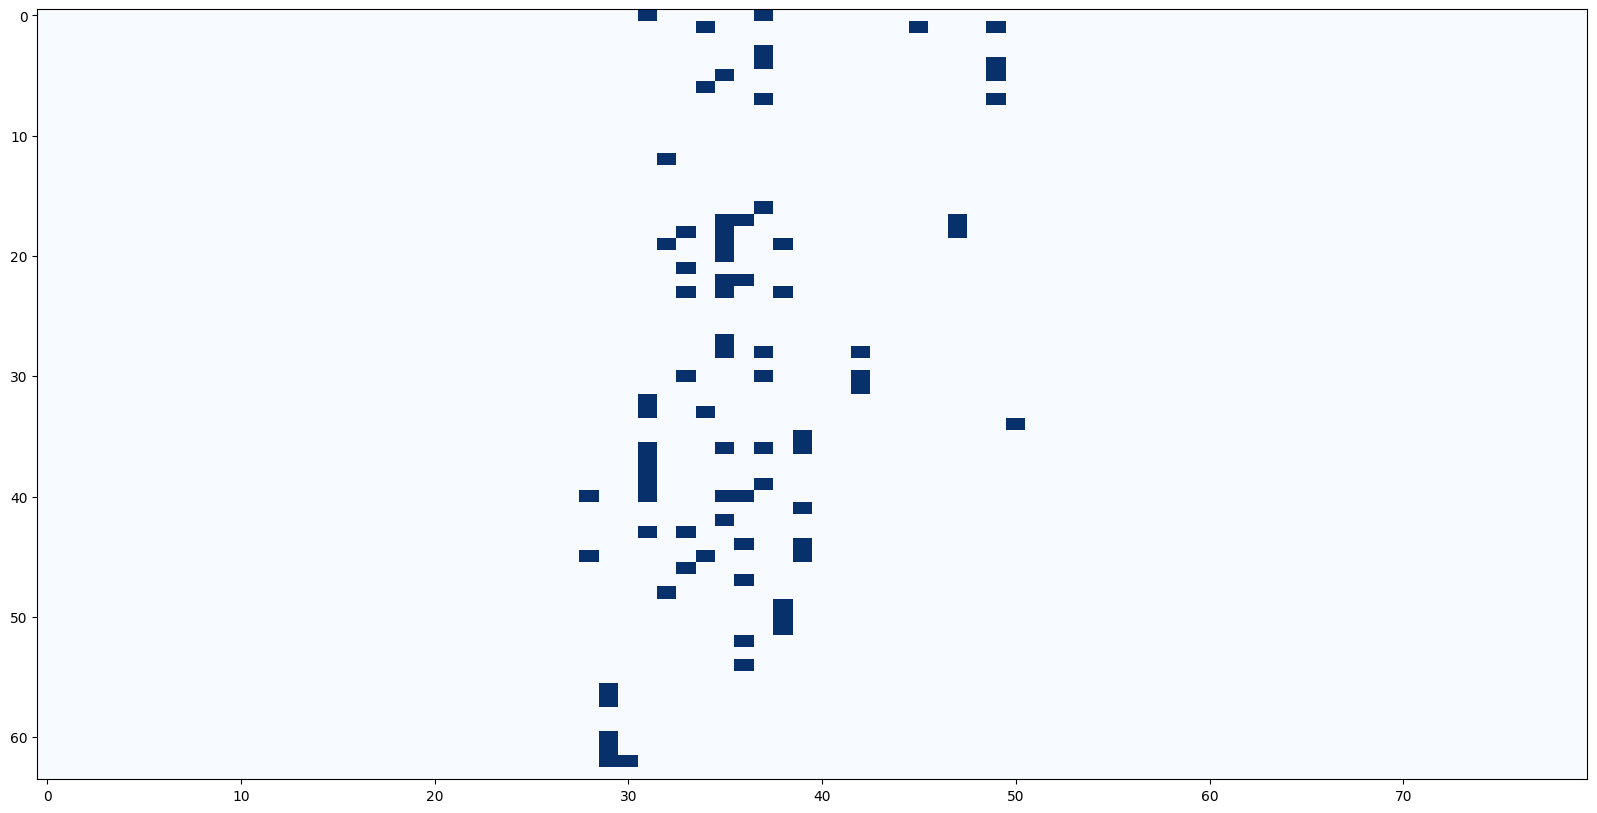

In [8]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

In [9]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-10 16:51:41 src.selection.functional DEBUG    Predictions: ['" Ki"[30558] (p=0.898, logit=22.625)', '" The"[578] (p=0.045, logit=19.625)', '" Among"[22395] (p=0.024, logit=19.000)', '" A"[362] (p=0.011, logit=18.250)', '" Fruit"[44187] (p=0.003, logit=16.875)']
2025-09-10 16:51:41 src.selection.functional INFO     Combined attention matrix for all heads


## Checking the effect of formatting

In [9]:
from src.selection.data import get_counterfactual_samples_within_task

clean_sample, patch_sample = get_counterfactual_samples_within_task(
    task=select_task,
    mt=mt,
    patch_category="fruit",
    clean_category="vehicle",
    distinct_options=True,
    n_distractors=5,
    filter_by_lm_prediction=False,
)

clean_sample.default_option_style = "bulleted"
patch_sample.default_option_style = "single_line"

assert clean_sample.default_option_style != patch_sample.default_option_style

print(
    "CLEAN:",
    clean_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"',
)
print(
    "PATCH:",
    patch_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"',
)

2025-09-15 13:46:17 src.selection.data INFO     clean_obj_idx=4 | ['Mango', 'Socks', 'Air fryer', 'Locket', 'Train', 'Skis']
type(task)=<class 'src.selection.data.SelectOneTask'>
CLEAN: # * Scooter
* Laptop
* Chair
* Kiwi
* Jacket
* Birch
Which among these objects mentioned above is a fruit?
Answer: >> " Ki"
PATCH: # Options: Mango, Socks, Air fryer, Locket, Train, Skis.
Which among these objects mentioned above is a vehicle?
Answer: >> " Train"


In [10]:
select_task.categories

['fruit',
 'vehicle',
 'furniture',
 'animal',
 'music instrument',
 'clothing',
 'electronics',
 'sport equipment',
 'kitchen appliance',
 'vegetable',
 'building',
 'office supply',
 'bathroom item',
 'flower',
 'tree',
 'jewelry']

# Validating Against Other Reduce Tasks

In [65]:
import random
from src.selection.data import get_counterfactual_samples_interface
from src.selection.data import YesNoTask, SelectFirstTask, CountingTask
from typing import Optional
import copy
from src.tokens import prepare_input
from src.selection.utils import verify_correct_option
from src.selection.data import get_options_for_answer


def get_task_specific_kwargs(task, distinct_options=True):
    kwargs = {}
    if isinstance(task, CountingTask):
        kwargs["clean_n_options"] = random.choice(range(4, 7))
        kwargs["patch_n_options"] = random.choice(range(4, 7))
        kwargs["distinct_options"] = distinct_options
    elif isinstance(task, YesNoTask):
        kwargs["clean_n_options"] = random.choice(range(3, 6))
        kwargs["patch_n_options"] = random.choice(range(3, 6))
        # No distinct options for yes/no task
    elif isinstance(task, SelectFirstTask | SelectLastTask):
        #! this has to come before SelectOneTask since SelectFirstTask is a subclass of SelectOneTask
        kwargs["distinct_options"] = distinct_options
        kwargs["n_distractors"] = random.choice(range(3, 6))
    elif isinstance(task, SelectOneTask):
        kwargs["distinct_options"] = distinct_options
        kwargs["patch_n_distractors"] = random.choice(range(2, 7))
        kwargs["clean_n_distractors"] = random.choice(range(2, 7))
    return kwargs


def get_counterfactual_samples_across_tasks(
    mt: ModelandTokenizer,
    patch_task,
    clean_task,
    patch_category: str,
    clean_category: str,
    patch_prompt_template_idx: int = 3,
    clean_prompt_template_idx: int = 3,
    clean_transform: Optional[callable] = None,
    patch_transform: Optional[callable] = None,
    filter_by_lm_prediction=False,
    retry_count=0,
):
    categories = patch_task.categories
    for category in clean_task.categories:
        assert category in categories, "Categories must be the same!"

    patch_category = patch_category or random.choice(categories)
    clean_category = clean_category or random.choice(
        list(set(categories) - {patch_category})
    )

    assert patch_category != clean_category, "Categories must be different!"

    patch_sample, _ = get_counterfactual_samples_interface[patch_task.task_name](
        mt=mt,
        task=patch_task,
        patch_category=patch_category,
        clean_category=clean_category,
        prompt_template_idx=patch_prompt_template_idx,
        filter_by_lm_prediction=False,
        **get_task_specific_kwargs(patch_task, distinct_options=True),
    )

    _, clean_sample = get_counterfactual_samples_interface[clean_task.task_name](
        mt=mt,
        task=clean_task,
        patch_category=patch_category,
        clean_category=clean_category,
        prompt_template_idx=clean_prompt_template_idx,
        filter_by_lm_prediction=False,
        **get_task_specific_kwargs(clean_task, distinct_options=True),
    )

    if patch_transform is not None:
        patch_sample = patch_transform(patch_sample)
    if clean_transform is not None:
        clean_sample = clean_transform(clean_sample)

    if "qwen" in mt.name.lower():
        # for attention sink
        clean_sample.prompt_template = (
            "# " + clean_sample.prompt_template
            if not clean_sample.prompt_template.startswith("#")
            else clean_sample.prompt_template
        )
        patch_sample.prompt_template = (
            "# " + patch_sample.prompt_template
            if not patch_sample.prompt_template.startswith("#")
            else patch_sample.prompt_template
        )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        gold_sample = copy.deepcopy(clean_sample)
        gold_sample.category = clean_sample.metadata["track_category"]
        gold_sample.ans_token_id = clean_sample.metadata["track_type_obj_token_id"]
        test_samples.append(gold_sample)

        for sample in test_samples:
            prompt = sample.prompt()
            tokenized_inputs = prepare_input(prompts=prompt, tokenizer=mt.tokenizer)
            sample.metadata["tokenized"] = tokenized_inputs.data

            print("-" * 80)
            print(sample.prompt(), ">>", mt.tokenizer.decode(sample.ans_token_id))

            is_correct, predictions, track_options = verify_correct_option(
                mt=mt,
                input=tokenized_inputs,
                target=sample.ans_token_id,
                options=get_options_for_answer(sample),
            )

            if is_correct is False:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                # for debugging
                if retry_count > 5:
                    raise ValueError("Max retries exceeded!")

                return get_counterfactual_samples_across_tasks(
                    mt=mt,
                    patch_task=patch_task,
                    clean_task=clean_task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    patch_prompt_template_idx=patch_prompt_template_idx,
                    clean_prompt_template_idx=clean_prompt_template_idx,
                    clean_transform=clean_transform,
                    patch_transform=patch_transform,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    retry_count=retry_count + 1,
                )

    return patch_sample, clean_sample

### Select One -- MCQ

In [29]:
from src.selection.data import SelectionSample, SelectOneTask

select_one_mcq = SelectOneTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
        # "profession.json"
        # "nationality.json"
        # "landmarks.json"
    )
)
print(select_one_mcq)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [21]:
import copy
from src.selection.utils import get_first_token_id
from src.functional import predict_next_token
from src.selection.data import MCQify_sample

test_sample = select_one_mcq.get_random_sample(
    mt=mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    # category="actor",
    # category="United Kingdom",
    filter_by_lm_prediction=True,
)

test_sample = MCQify_sample(mt, test_sample)
print(
    test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"'
)

predict_next_token(mt=mt, inputs=test_sample.prompt())

# a. Submarine
b. Factory
c. Coffee maker
d. Pencil
e. Harp
f. Mango
Which among these objects mentioned above is a fruit?
Answer: >> " f"


[[PredictedToken(token=' f', prob=0.69140625, logit=27.25, token_id=282, metadata=None),
  PredictedToken(token=' The', prob=0.13671875, logit=25.625, token_id=576, metadata=None),
  PredictedToken(token=' Mango', prob=0.056884765625, logit=24.75, token_id=90863, metadata=None),
  PredictedToken(token=' Among', prob=0.030517578125, logit=24.125, token_id=21658, metadata=None),
  PredictedToken(token=' F', prob=0.02685546875, logit=24.0, token_id=434, metadata=None)]]

In [22]:
def mcq_transform(sample):
    sample = MCQify_sample(mt=mt, sample=sample)
    if "track_type_obj_token_id" in sample.metadata:
        patch_obj_idx = sample.metadata["track_type_obj_idx"]
        sample.metadata["track_type_obj_token_id"] = get_first_token_id(
            name=chr(ord("a") + patch_obj_idx), tokenizer=mt.tokenizer, prefix=" "
        )
    return sample


patch_sample, clean_sample = get_counterfactual_samples_across_tasks(
    mt=mt,
    patch_task=select_task,
    clean_task=select_one_mcq,
    patch_category="fruit",
    clean_category="vehicle",
    clean_transform=mcq_transform,
    filter_by_lm_prediction=True
)

print(
    "CLEAN:",
    clean_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"',
)
print(
    "PATCH:",
    patch_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"',
)

2025-09-15 13:48:32 src.selection.data INFO     clean_obj_idx=0 | ['Airplane', 'Tennis ball', 'Ruler', 'Monitor', 'Grape']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-15 13:48:32 src.selection.data INFO     clean_obj_idx=4 | ['Grape', 'School', 'Sheep', 'Marker', 'Tractor']
type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------------------------------------------------------------
# Options: Helicopter, Pineapple, Charm.
Which among these objects mentioned above is a fruit?
Answer: >>  Pine
--------------------------------------------------------------------------------
# a. Grape
b. School
c. Sheep
d. Marker
e. Tractor
Which among these objects mentioned above is a vehicle?
Answer: >>  e
--------------------------------------------------------------------------------
# a. Grape
b. School
c. Sheep
d. Marker
e. Tractor
Which among these objects mentioned above is a fruit?
Answer: >>  a
CLEAN: # a. Grape
b. School
c. Sheep
d. Marker
e. Tractor
Which among these objects mentioned above is a vehicle?
Answer: >> " e"
PATCH: # Options: Helicopter, Pineapple, Charm.
Whi

In [23]:
clean_sample.metadata, mt.tokenizer.decode([clean_sample.ans_token_id])

({'track_category': 'fruit',
  'track_type_obj': 'Grape',
  'track_type_obj_idx': 0,
  'track_type_obj_token_id': 264,
  'ques_pos': 23,
  'tokenized': {'input_ids': tensor([[    2,   264,    13, 79529,   198,    65,    13,  6022,   198,    66,
               13, 82908,   198,    67,    13, 39875,   198,    68,    13,  1163,
             5621,   198, 23085,  4221,  1493,  6171,  9733,  3403,   374,   264,
             7310,  5267, 16141,    25]]),
   'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])},
  'question_type': 'MCQ'},
 ' e')

### SelectFirstTask

In [41]:
from src.selection.data import SelectionSample, SelectFirstTask

select_first_task = SelectFirstTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(select_first_task)

SelectFirstTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [42]:
test_sample = select_first_task.get_random_sample(
    mt = mt,
    option_style="single_line",
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
)
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Options: Rice cooker, Charm, Kiwi, Plum, Church, Blueberry, Scissors, Cat.
What is the first fruit from the list above?
Answer: >> " Ki"


[PredictedToken(token=' The', prob=0.7734375, logit=32.75, token_id=576, metadata=None),
 PredictedToken(token=' Ki', prob=0.2216796875, logit=31.5, token_id=29458, metadata=None),
 PredictedToken(token=' To', prob=0.001495361328125, logit=26.5, token_id=2014, metadata=None),
 PredictedToken(token=' Plum', prob=0.0004863739013671875, logit=25.375, token_id=83309, metadata=None),
 PredictedToken(token=' From', prob=0.00017833709716796875, logit=24.375, token_id=5542, metadata=None)]

In [46]:
patch_sample, clean_sample = get_counterfactual_samples_across_tasks(
    mt=mt,
    patch_task=select_task,
    clean_task=select_first_task,
    patch_category="fruit",
    clean_category="vehicle",
    clean_transform=None,
    filter_by_lm_prediction=True
)

print(
    "CLEAN:",
    clean_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"',
)
print(
    "PATCH:",
    patch_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"',
)

2025-09-15 13:58:51 src.selection.data INFO     clean_obj_idx=2 | ['Strawberry', 'Mall', 'Helicopter', 'Television', 'Suit', 'Blender']


type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------------------------------------------------------------
# Options: Bracelet, Pear, Bike.
Which among these objects mentioned above is a fruit?
Answer: >>  Pear
--------------------------------------------------------------------------------
# Options: Pear, Helicopter, Boat, Dumbbell, Peach.
What is the first vehicle from the list above?
Answer: >>  Hel
--------------------------------------------------------------------------------
# Options: Pear, Helicopter, Boat, Dumbbell, Peach.
What is the first fruit from the list above?
Answer: >>  Pear
CLEAN: # Options: Pear, Helicopter, Boat, Dumbbell, Peach.
What is the first vehicle from the list above?
Answer: >> " Hel"
PATCH: # Options: Bracelet, Pear, Bike.
Which among these objects mentioned above is a fruit?
Answer: >> " Pear"


### SelectLastTask

In [53]:
from src.selection.data import SelectionSample, SelectLastTask

select_last_task = SelectLastTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(select_first_task)

SelectFirstTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [54]:
test_sample = select_last_task.get_random_sample(
    mt = mt,
    option_style="single_line",
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
)
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

2025-09-15 14:02:00 src.selection.data ERROR    Sample = Kiwi -> Cherry (5): ['Smartwatch', 'Skis', 'Chair', 'Pineapple', 'Mango', 'Cherry', 'Scooter', 'Ukulele']
Top prediction (2, PredictedToken(token=' Mango', prob=0.032470703125, logit=27.0, token_id=90863, metadata=None)) does not match the object 44705, " Cherry".
Retry count: 1. Retrying ...
Options: Kiwi, Chair, Cherry, Phone, Pressure cooker, Comb, Trombone.
What is the last fruit in this list above?
Answer: >> " Cherry"


[PredictedToken(token=' The', prob=0.6875, logit=31.625, token_id=576, metadata=None),
 PredictedToken(token=' Cherry', prob=0.287109375, logit=30.75, token_id=44705, metadata=None),
 PredictedToken(token=' To', prob=0.026611328125, logit=28.375, token_id=2014, metadata=None),
 PredictedToken(token=' In', prob=0.000179290771484375, logit=23.375, token_id=758, metadata=None),
 PredictedToken(token=' Cher', prob=6.580352783203125e-05, logit=22.375, token_id=55107, metadata=None)]

In [66]:
get_task_specific_kwargs(select_last_task)

{'distinct_options': True, 'n_distractors': 3}

In [67]:
patch_sample, clean_sample = get_counterfactual_samples_across_tasks(
    mt=mt,
    patch_task=select_task,
    clean_task=select_last_task,
    patch_category="fruit",
    clean_category="vehicle",
    clean_transform=None,
    filter_by_lm_prediction=True
)

print(
    "CLEAN:",
    clean_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"',
)
print(
    "PATCH:",
    patch_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"',
)

2025-09-15 14:06:45 src.selection.data INFO     clean_obj_idx=2 | ['Plum', 'Ruler', 'Truck']


type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------------------------------------------------------------
# Options: Television, Cherry, Racket, Bike.
Which among these objects mentioned above is a fruit?
Answer: >>  Cherry
--------------------------------------------------------------------------------
# Options: Ash, Airplane, Pineapple, Blueberry, Yacht.
What is the last vehicle in this list above?
Answer: >>  Y
--------------------------------------------------------------------------------
# Options: Ash, Airplane, Pineapple, Blueberry, Yacht.
What is the last fruit in this list above?
Answer: >>  Blue
CLEAN: # Options: Ash, Airplane, Pineapple, Blueberry, Yacht.
What is the last vehicle in this list above?
Answer: >> " Y"
PATCH: # Options: Television, Cherry, Racket, Bike.
Which among these objects mentioned above is a fruit?
Answer: >> " Cherry"


## Counting Task

In [68]:
from src.selection.data import CountingSample, CountingTask

counting_task = CountingTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(counting_task)

CountingTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)


In [69]:
test_sample = counting_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
)

print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Items: Apple, Mango, Comb, Harp, Sunflower
How many fruits are in this list?
Answer:  >> " Two"


[PredictedToken(token=' Two', prob=1.4722347259521484e-05, logit=24.375, token_id=9043, metadata=None),
 PredictedToken(token=' Three', prob=2.066371962428093e-09, logit=15.5, token_id=14513, metadata=None),
 PredictedToken(token=' One', prob=1.2369127944111824e-10, logit=12.6875, token_id=3776, metadata=None),
 PredictedToken(token=' Four', prob=3.774403012357652e-11, logit=11.5, token_id=13322, metadata=None),
 PredictedToken(token=' Five', prob=8.412825991399586e-12, logit=10.0, token_id=20924, metadata=None),
 PredictedToken(token=' Zero', prob=3.8191672047105385e-13, logit=6.90625, token_id=18306, metadata=None),
 PredictedToken(token=' Six', prob=2.9665159217984183e-13, logit=6.65625, token_id=18680, metadata=None),
 PredictedToken(token=' Seven', prob=1.9184653865522705e-13, logit=6.21875, token_id=29948, metadata=None),
 PredictedToken(token=' Ten', prob=1.5898393712632242e-13, logit=6.03125, token_id=17695, metadata=None),
 PredictedToken(token=' Eight', prob=7.993605777301127

In [76]:
patch_sample, clean_sample = get_counterfactual_samples_across_tasks(
    mt=mt,
    patch_task=select_task,
    clean_task=counting_task,
    patch_category="fruit",
    clean_category="vehicle",
    clean_transform=None,
    filter_by_lm_prediction=True,
)

print(
    "CLEAN:",
    clean_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"',
)
print(
    "PATCH:",
    patch_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"',
)

print(
    clean_sample.metadata["track_type_obj_token_id"],
    mt.tokenizer.decode(clean_sample.metadata["track_type_obj_token_id"]),
)

2025-09-15 14:59:28 src.selection.data INFO     clean_obj_idx=0 | ['Boat', 'Locket', 'Orchid', 'Scarf', 'Strawberry']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-15 14:59:28 src.selection.data DEBUG    clean_category='vehicle' | clean_sample.options=['Ambulance', 'Yacht', 'Submarine', 'Cherry', 'Blueberry']
2025-09-15 14:59:28 src.selection.data DEBUG    patch_category='fruit' | patch_sample.options=['Tractor', 'Peach', 'Plum', 'Banana']
--------------------------------------------------------------------------------
# Options: Train, Mango, Smartwatch.
Which among these objects mentioned above is a fruit?
Answer: >>  Mango
--------------------------------------------------------------------------------
# Items: Ambulance, Yacht, Submarine, Cherry, Blueberry
How many vehicles are in this list?
Answer:  >>  Three
--------------------------------------------------------------------------------
# Items: Ambulance, Yacht, Submarine, Cherry, Blueberry
How many fruits are in this list?
Answer:  >>  Two
CLEAN: # Items: Ambulance, Yacht, Submarine, Cherry, Blueberry
How many vehicles are in 

### Yes/No Task

In [77]:
from src.selection.data import YesNoSample, YesNoTask

yes_no_task = YesNoTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(yes_no_task)

YesNoTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)


In [78]:
test_sample = counting_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
)

print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Items: Cherry, Elephant, Kiwi, Bench, Tablet
How many fruits are in this list?
Answer:  >> " Two"


[PredictedToken(token=' Two', prob=4.1425228118896484e-06, logit=21.875, token_id=9043, metadata=None),
 PredictedToken(token=' Three', prob=9.778887033462524e-08, logit=18.125, token_id=14513, metadata=None),
 PredictedToken(token=' One', prob=2.2737367544323206e-10, logit=12.0625, token_id=3776, metadata=None),
 PredictedToken(token=' Four', prob=1.864464138634503e-11, logit=9.5625, token_id=13322, metadata=None),
 PredictedToken(token=' Five', prob=5.030642569181509e-12, logit=8.25, token_id=20924, metadata=None),
 PredictedToken(token=' Zero', prob=2.4442670110147446e-12, logit=7.53125, token_id=18306, metadata=None),
 PredictedToken(token=' Six', prob=7.034373084024992e-13, logit=6.28125, token_id=18680, metadata=None),
 PredictedToken(token=' Ten', prob=4.263256414560601e-13, logit=5.78125, token_id=17695, metadata=None),
 PredictedToken(token=' Seven', prob=2.9309887850104133e-13, logit=5.40625, token_id=29948, metadata=None),
 PredictedToken(token=' Eight', prob=2.8421709430404

In [83]:
patch_sample, clean_sample = get_counterfactual_samples_across_tasks(
    mt=mt,
    patch_task=select_task,
    clean_task=yes_no_task,
    patch_category="fruit",
    clean_category="vehicle",
    clean_transform=None,
    filter_by_lm_prediction=True,
)

print(
    "CLEAN:",
    clean_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"',
)
print(
    "PATCH:",
    patch_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"',
)

print(
    clean_sample.metadata["track_type_obj_token_id"],
    mt.tokenizer.decode(clean_sample.metadata["track_type_obj_token_id"]),
)

2025-09-15 15:05:00 src.selection.data INFO     clean_obj_idx=1 | ['Jacket', 'Helicopter', 'Surfboard', 'Apple', 'Tiara']


type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------------------------------------------------------------
# Options: Ambulance, Mosque, Cherry, Coat, Food processor, Tablet.
Which among these objects mentioned above is a fruit?
Answer: >>  Cherry
--------------------------------------------------------------------------------
# Items: Stool, Cherry, Shower, Bat, Mall
Do you see a vehicle in the list above?
Answer: >>  No
--------------------------------------------------------------------------------
# Items: Stool, Cherry, Shower, Bat, Mall
Do you see a fruit in the list above?
Answer: >>  Yes
2025-09-15 15:05:00 __main__ ERROR    Prediction mismatch: (1, PredictedToken(token=' No', prob=0.92578125, logit=32.0, token_id=2308, metadata=None))[" No"] != 7414[" Yes"]
2025-09-15 15:05:00 src.selection.data INFO     clean_obj_idx=5 | ['Dog', 'Ottoman', 'Tulip', 'Kiwi', 'Mosque', 'Helicopter', 'Ring']
type(task)=<class 'src.selection.data.SelectOneTask'>
-------